In [61]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from collections import defaultdict, Counter

import pandas as pd

In [3]:
data_dir = "./data/"

In [10]:
cans = pd.read_csv(data_dir + 'cans.csv')
cans

,vid,vid_
0,5bc78a50602b520bb3f6c87e3c542f1c,53634
1,73e37445d73561ffdf0711a3ffe4ca25,67745
2,bb639a67990c3b4ab3b51f7f7b1dbbb0,109429
3,29d0413f14eb1fbd8b5b43946b77f73a,24172
4,773e052e4aa8f09ed9f54f1f2699fc07,69757
...,...,...
13401,f3c19753a76e0e97f92dc715a8ee8c2b,142468
13402,607619c7529cf88720598c96402c0703,56365
13403,8e8b692d0670cca0099483ac0310f62e,83309
13404,f865e9c6257a4f6e811a9b4dc2b4ed75,145178


In [14]:
with open(data_dir + 'history.pkl', 'rb') as f:
    did_his = pickle.load(f)

# Overview
基于规则的方法效果有限，还是得上模型啊。既然要训模型，那么肯定是要构造数据集的。细想一下，可能主要要解决的问题是：
- 构造用于训模型的数据集；
- 为每个用户召回一定量的物品；

一些参考：
- [H&M Personalized Fashion Recommendations 1st place solution](https://www.kaggle.com/competitions/h-and-m-personalized-fashion-recommendations/discussion/324070)

# 召回
召回主要是基于用户信息、物品信息、用户行为信息，在当前环境下，召回一组物品。一些召回方法：
- 关联的召回；
- 热门召回；
- 类别 / 风格召回；
- 图上的随机游走召回；
- 向量召回；

召回的结果可以用于：
- 构造训练集；
- 也可以用于为每个用户召回一定量的结果然后进行打分排序后作为提交结果；  
第二种怎么做是很明了的，但是怎么构造训练集呢？

## 关联召回

In [7]:
with open(data_dir + 'edges_.pkl', 'rb') as f:
    edges_ = pickle.load(f)
    out_edges_ = edges_['out']
    in_edges_  = edges_['in']

In [21]:
# 找到每个用户最后一次观看的视频
rec_link = defaultdict(list)
cans_vid = set(cans['vid_'])
null_did_link = []

for i, (k, v) in enumerate(did_his.items()):
    tmp = []
    v = v[-1]
    if v in out_edges_:
        # tmp = [e[0] for e in out_edges_[v].most_common()]
        for e in out_edges_[v].most_common():
            if e[0] not in tmp and e[0] in cans_vid:
                tmp.append(e[0])
        
    if len(tmp) < 6 and v in in_edges_:  # 如果找不到 6 个，则用其入边填充
        # n = 6 - len(tmp)
        for e in in_edges_[v].most_common():
            if e[0] not in tmp and e[0] in cans_vid:
                tmp.append(e[0])
    
    
    rec_link[k] = tmp
    if len(tmp) == 0:
        # print('Link recall get nothing for user: %d' % k)
        null_did_link.append(k)
    
    if i % 10000 == 0:
        print('%d / %d' % (i, len(did_his)))

print('Link recall get nothing for %d dids: %s' % (len(null_did_link), null_did_link))

0 / 170909
10000 / 170909
20000 / 170909
30000 / 170909
40000 / 170909
50000 / 170909
60000 / 170909
70000 / 170909
80000 / 170909
90000 / 170909
100000 / 170909
110000 / 170909
120000 / 170909
130000 / 170909
140000 / 170909
150000 / 170909
160000 / 170909
170000 / 170909
Link recall get nothing for 971 dids: [57, 327, 331, 543, 765, 871, 1023, 1073, 1529, 1595, 1612, 1685, 1839, 1879, 2036, 2196, 2393, 2566, 2691, 2916, 3078, 3268, 3286, 3504, 3595, 3684, 3777, 3986, 4005, 4143, 4508, 4552, 4571, 4698, 5061, 5302, 5886, 5902, 6201, 6268, 6907, 6945, 7073, 7133, 7181, 7580, 7630, 7650, 8314, 8389, 8418, 8775, 9441, 9831, 9847, 9910, 10248, 10326, 10616, 10683, 10702, 10813, 11028, 11104, 11109, 11729, 11766, 11785, 11943, 12043, 12178, 12204, 12536, 12649, 13327, 13341, 13620, 13735, 14563, 14639, 15108, 15628, 15789, 15994, 16073, 16311, 16331, 16401, 16476, 16606, 16767, 16846, 16900, 17425, 17610, 17876, 18031, 18196, 18541, 18634, 18715, 19181, 19352, 19409, 19729, 19758, 19909, 1

## 热门召回

In [26]:
with open(data_dir + 'hot_list.pkl', 'rb') as f:
    hot_list = pickle.load(f)

In [28]:
rec_hot = {}
cans_vid = set(cans['vid_'])
null_did_hot = []

# for i, (k, v) in enumerate(did_his.items()):
    

## 类别/风格召回
类别/风格可以是合集、视频类型、系列、频道类型、视频的明星集合、关键词、标签 (好吧，基本上把视频的属性全都包括进行来了），这有点类似于搜索中的基于 term 的匹配了，一种硬匹配。

## 随机游走召回
构建 (有向) 图，在图上进行随机游走。怎么构建这个图呢？
- 一种简单的做法是基于关联数据构建；
- **?**

## 向量召回
获得视频的表征向量，通过向量的 KNN 来做召回。虽然获得视频向量时，利用的信息大部分还是来自视频的信息，但与类被/风格召回不同之处在于：向量召回能够发掘视频啊之间的深层关系/语义关系，是一种软匹配。

## 随机召回


## 衡量召回的效果
怎么知道我召回的效果好坏呢？召回率。

# 构造训练集
这里的训练集指的是用于训练打分模型的数据集。其样本构造为 $(did, context, vid, label)$，其中 $label \in \{0, 1\}$，表示是否观看。需要斟酌一下 context 该如何定义：
- 用户的观看行为序列；
- 相关的统计特征；  

这 context 还挺难搞的啊，算了，先把数据切分成一组一组的吧:

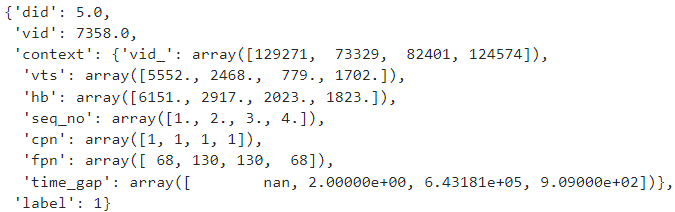

**由于按照用户进行分组后，每个用户的行为数据都变成了一个序列，例如观看过的视频是一个序列、vts 也是一个序列等，如何将这些序列变成一个特征，或者变成一个向量**：

- 基于历史视频序列构建对应的统计特征，例如：
    - 行为序列中观看的视频的类型的分布，这里的类型可以是 is_intact、classify_id、upgc；
    - 历史视频序列种视频时长的统计特征；
    - 标题长度的统计特征；
- 观看视频的时间间隔（time_gap）;
- 集合特征，Embedding 后进行聚合（Mean, Max, Concat 等），如 
    - tags、keywords、stars；
    - vid，did；
- 候选物品的特征，如候选视频的类型、频道类型等；
- 候选视频与行为的交叉特征，例如：
    - 最后一次看与候选视频同类型视频的时间、时间间隔等；
    - 候选视频的合集/系列与历史行为的关系，如与最后一个行为是否相同，历史行为中相同合集/系列的占比等；
    

正样本集，一种比较直接的方式是根据行为序列来构建，即序列中的每个物品和用户构成一个正样本，重点是如何构造负例。构造负例的方法：
- 随机选取热门物品作为负例；
- 从同类别的视频里选择；
- 随机选择；
- 召回后的负例；

In [63]:
main = pd.read_csv(data_dir + 'main.csv').iloc[:, 2:]
main

,vts,hb,seq_no,cpn,fpn,time_gap,did_,vid_
0,111.0,84.0,5.0,1,130,87.0,63411,77036
1,114.0,85.0,4.0,1,130,115.0,63411,14321
2,137.0,80.0,3.0,1,130,75.0,63411,23052
3,91.0,74.0,2.0,1,130,90.0,63411,24779
4,118.0,86.0,1.0,1,130,NaN,63411,86561
...,...,...,...,...,...,...,...,...
5596408,27.0,2456.0,5.0,1,130,33.0,121675,78186
5596409,52.0,2351.0,4.0,1,130,42.0,121675,139535
5596410,51.0,2064.0,3.0,1,130,5.0,121675,143599
5596411,186.0,2033.0,2.0,1,68,160376.0,121675,95951


In [110]:
vinfo = pd.read_csv(data_dir + 'vinfo.csv').iloc[:, 3:]
vinfo.head()

,serialno,classify_id,series_id,duration,title_length,upgc_flag,stars,tags,key_word,vid_,cid_,is_intact_,classify_id_
0,0,1,0,99,65,0,"[101000001, 101006658, 101028796]","[101000002, 101000004, 101000005, 101000006, 1...","['386650', '726773', '574504', '401841', '7711...",1812,2909,3,0
1,0,1,0,120,91,0,"[101001415, 101002401]","[101000001, 101000002, 101000004, 101000005, 1...","['333465', '401841', '726773', '574504', '7711...",64260,2909,2,0
2,0,1,0,116,87,0,"[101000002, 101002435]","[101000001, 105020769, 101000004, 101000005, 1...","['504899', '401841', '726773', '574504', '7711...",87443,2909,2,0
3,0,1,0,25,73,0,[101004657],"[101000001, 101000002, 101000004, 101000005, 1...","['148961', '504899', '401841', '574504', '7267...",144235,2909,2,0
4,0,1,0,35,79,0,"[101000005, 101000007]","[101000001, 101000002, 101000004, 101000006, 1...","['615333', '388519', '401841', '574504', '7269...",30724,2909,2,0


In [35]:
g = main.groupby('did_')

In [97]:
def generate_negtive(his_df):
    """
    根据一个用户的历史行为生成负样本
    """
    
    pass


def generate_meta_sample(his_df, container=None):
    """
    根据一个用户的历史行为生成正样本
    """
    his_df = his_df.sort_values('seq_no')
    context = {}
    # last = his_df.iloc[-1]['vid_']
    # his_df = his_df.iloc[:-1]
    cols = ['vid_', 'vts', 'hb', 'seq_no', 'cpn', 'fpn', 'time_gap']
    for col in cols:
        values = his_df[col].values
        if np.isnan(values).sum() == 0:
            values = values.astype(int)
        context[col] = values
    sample = {}
    sample['did'] = int(his_df.iloc[0]['did_'])
    # sample['vid'] = last 
    sample['context'] = context
    # sample['label'] = 1
    if container:
        container[his_df.iloc[0]['did_']] = sample
    return sample

In [100]:
all_meta_samples = {}
for i, (k, v) in enumerate(g):
    sample = generate_meta_sample(v)
    all_meta_samples[k] = sample
    if i % 10000 == 0:
        print('%d / %d' % (i, len(g)))

0 / 170909
10000 / 170909
20000 / 170909
30000 / 170909
40000 / 170909
50000 / 170909
60000 / 170909
70000 / 170909
80000 / 170909
90000 / 170909
100000 / 170909
110000 / 170909
120000 / 170909
130000 / 170909
140000 / 170909
150000 / 170909
160000 / 170909
170000 / 170909


In [98]:
generate_meta_sample(g.get_group(5))

{'did': 5,
 'context': {'vid_': array([129271,  73329,  82401, 124574,   7358]),
  'vts': array([5552, 2468,  779, 1702, 3960]),
  'hb': array([6151, 2917, 2023, 1823, 6214]),
  'seq_no': array([1, 2, 3, 4, 5]),
  'cpn': array([1, 1, 1, 1, 1]),
  'fpn': array([ 68, 130, 130,  68,  68]),
  'time_gap': array([        nan, 2.00000e+00, 6.43181e+05, 9.09000e+02, 3.81938e+05])}}

In [66]:
g.get_group(5).sort_values('seq_no')

,vts,hb,seq_no,cpn,fpn,time_gap,did_,vid_
2189600,5552.0,6151.0,1.0,1,68,NaN,5,129271
2189599,2468.0,2917.0,2.0,1,130,2.0,5,73329
2189598,779.0,2023.0,3.0,1,130,643181.0,5,82401
2189597,1702.0,1823.0,4.0,1,68,909.0,5,124574
2189596,3960.0,6214.0,5.0,1,68,381938.0,5,7358


In [171]:
all_meta_samples[0]

{'did': 0,
 'context': {'vid_': array([145230, 148364,  25648, 111474,  39871,  75604]),
  'vts': array([  44, 1260,  780, 2714, 1620, 3300]),
  'hb': array([3286, 3698, 7715, 2611, 1983, 6356]),
  'seq_no': array([1, 2, 3, 4, 5, 6]),
  'cpn': array([1, 1, 1, 1, 1, 1]),
  'fpn': array([130, 130, 130,  68, 130, 130]),
  'time_gap': array([        nan, 1.08000e+02, 5.76450e+04, 5.46847e+05, 3.10300e+03,
         4.62500e+03])}}

In [156]:
tmp1 = {1:1}
tmp1.update({2:2})
tmp1

{1: 1, 2: 2}

## 构造特征

In [201]:
def hist_stat(hist, vinfo_df):
    """
    基于观看序列构建统计特征
    -----
    hist: 观看的视频序列;
    vinfo_df: 视频的信息表，已经将视频 id 作为索引；
    """
    # 取出相应视频的信息
    info = vinfo_df.iloc[hist]
    
    # is_intact 类别分布
    is_intact = dict(zip(vinfo_df['is_intact_'].unique(), [0]*vinfo_df['is_intact_'].nunique()))
    tmp = info['is_intact_'].value_counts().to_dict()
    is_intact.update(tmp)
    is_intact = {f'is_intact_{k}': v for k, v in is_intact.items()}
    
    # classfiy_id 类别分布
    classify_id = dict(zip(vinfo_df['classify_id_'].unique(), [0]*vinfo_df['classify_id_'].nunique()))
    tmp = info['classify_id_'].value_counts().to_dict()
    classify_id.update(tmp)
    classify_id = {f'classify_id_{k}': v for k, v in classify_id.items()}
    
    # upgc
    upgc = dict(zip(vinfo_df['upgc_flag'].unique(), [0]*vinfo_df['upgc_flag'].nunique()))
    tmp = info['upgc_flag'].value_counts().to_dict()
    upgc.update(tmp)
    upgc = {f'upgc_{k}': v for k, v in upgc.items()}
    
    # duration 的统计特征
    duration_max = info['duration'].max()
    duration_min = info['duration'].min()
    duration_mean = info['duration'].mean()
    duration = {'duration_max': duration_max, 'duration_min': duration_min, 'duration_mean': duration_mean}
    
    # title_length 的统计特征
    tl_max = info['title_length'].max()
    tl_min = info['title_length'].min()
    tl_mean = info['title_length'].mean()
    tl = {'title_length_max': tl_max, 'title_length_min': tl_min, 'title_length_mean': tl_mean}
    
    feature = {}
    feature.update(is_intact)
    feature.update(classify_id)
    feature.update(upgc)
    feature.update(duration)
    feature.update(tl)
    
    return feature


def candidate_hist(item, hist, vinfo_df):
    """
    构建候选物品与历史行为的交叉特征
    -----
    item: 候选物品（vid_）
    hist: 观看的视频序列;
    vinfo_df: 视频的信息表，已经将视频 id 作为索引；
    """
    feature = {}
    
    # 取出相应视频的信息
    hist_info = vinfo_df.iloc[hist]
    item_info = vinfo_df.iloc[item]
    
    # 与历史最后一个视频是否同一系列 / 合集 / 视频类型 / upgc / 频道类型
    cols1 = ['series_id', 'cid_', 'is_intact_', 'upgc_flag', 'classify_id_']
    for c in cols1:
        feature[f'is_same_{c}'] = item_info[c] == hist_info.iloc[-1][c]
    
    # 候选视频类别在历史视频的类别中出现的次数/占比
    cols2 = ['series_id', 'cid_', 'is_intact_', 'upgc_flag', 'classify_id_']
    for c in cols2:
        feature[f'same_{c}_count'] = (hist_info[c] == item_info[c]).sum()
        feature[f'same_{c}_ratio'] = (hist_info[c] == item_info[c]).sum() / len(hist_info)
        
    # 候选视频的集合特征与最后一个历史视频的集合特征的交集的占比（杰卡德系数）
    cols3 = ['stars', 'tags', 'key_word']
    for c in cols3:
        s1 = set(eval(item_info[c]))
        s2 = set(eval(hist_info.iloc[-1][c]))
        tmp1 = len(s1 & s2)
        tmp2 = len(s1 | s2)
        feature[f'{c}_intersect_count'] = tmp1
        feature[f'{c}_intersect_ratio'] = 0 if tmp2 == 0 else tmp1 / tmp2
    
    # 暂时想不到了
    return feature


def generate_samples(meta_samples):
    """
    基于输入的历史行为，生成正负样本
    -----
    
    """
    # 观看序列的统计特征
    
    # 生成正样本的同时生成负样本
    
    pass

In [186]:
g.get_group(0)

,vts,hb,seq_no,cpn,fpn,time_gap,did_,vid_
2696555,3300.0,6356.0,6.0,1,130,4625.0,0,75604
2696556,1620.0,1983.0,5.0,1,130,3103.0,0,39871
2696557,2714.0,2611.0,4.0,1,68,546847.0,0,111474
2696558,780.0,7715.0,3.0,1,130,57645.0,0,25648
2696559,1260.0,3698.0,2.0,1,130,108.0,0,148364
2696560,44.0,3286.0,1.0,1,130,NaN,0,145230


In [179]:
hist_stat(all_meta_samples[0]['context']['vid_'], vinfo.set_index('vid_').sort_index())

{'is_intact_0': 6,
 'is_intact_1': 0,
 'is_intact_3': 0,
 'is_intact_2': 0,
 'is_intact_5': 0,
 'is_intact_6': 0,
 'is_intact_4': 0,
 'is_intact_7': 0,
 'is_intact_8': 0,
 'classify_id_4': 0,
 'classify_id_1': 0,
 'classify_id_9': 0,
 'classify_id_0': 6,
 'classify_id_6': 0,
 'classify_id_12': 0,
 'classify_id_5': 0,
 'classify_id_2': 0,
 'classify_id_10': 0,
 'classify_id_8': 0,
 'classify_id_3': 0,
 'classify_id_7': 0,
 'classify_id_11': 0,
 'upgc_0': 6,
 'upgc_1': 0,
 'duration_max': 7918,
 'duration_min': 2717,
 'duration_mean': 5204.333333333333,
 'title_length_max': 47,
 'title_length_min': 47,
 'title_length_mean': 47.0}

In [202]:
candidate_hist(75604, all_meta_samples[0]['context']['vid_'], vinfo.set_index('vid_').sort_index())

{'is_same_series_id': True,
 'is_same_cid_': True,
 'is_same_is_intact_': True,
 'is_same_upgc_flag': True,
 'is_same_classify_id_': True,
 'same_series_id_count': 6,
 'same_series_id_ratio': 1.0,
 'same_cid__count': 6,
 'same_cid__ratio': 1.0,
 'same_is_intact__count': 6,
 'same_is_intact__ratio': 1.0,
 'same_upgc_flag_count': 6,
 'same_upgc_flag_ratio': 1.0,
 'same_classify_id__count': 6,
 'same_classify_id__ratio': 1.0,
 'stars_intersect_count': 7,
 'stars_intersect_ratio': 1.0,
 'tags_intersect_count': 0,
 'tags_intersect_ratio': 0,
 'key_word_intersect_count': 14,
 'key_word_intersect_ratio': 1.0}

In [190]:
vinfo.iloc[all_meta_samples[0]['context']['vid_']].iloc[-1]['is_intact_']

0

In [199]:
vinfo.set_index('vid_').sort_index().iloc[all_meta_samples[0]['context']['vid_']]

,serialno,classify_id,series_id,duration,title_length,upgc_flag,stars,tags,key_word,cid_,is_intact_,classify_id_
vid_,,,,,,,,,,,,
145230,34,1,51680,3503,47,0,"[101022021, 101000052, 101004074, 101000132, 1...",[],"['889054', '389247', '615333', '726773', '4718...",6974,0,0
148364,35,1,51680,5166,47,0,"[101022021, 101000052, 101004074, 101000132, 1...",[],"['889054', '389247', '615333', '726773', '4718...",6974,0,0
25648,37,1,51680,7918,47,0,"[101004074, 101000052, 101003844, 101000132, 1...",[],"['889054', '421542', '196986', '389247', '6153...",6974,0,0
111474,38,1,51680,2717,47,0,"[101004074, 101000052, 101003844, 101000132, 1...",[],"['889054', '421542', '196986', '389247', '6153...",6974,0,0
39871,39,1,51680,5401,47,0,"[101004074, 101000052, 101003844, 101000132, 1...",[],"['889054', '421542', '196986', '389247', '6153...",6974,0,0
75604,41,1,51680,6521,47,0,"[101000052, 101004074, 101003844, 101000002, 1...",[],"['889054', '389247', '726773', '471819', '4712...",6974,0,0


In [196]:
all_meta_samples[0]['context']['vid_']

array([145230, 148364,  25648, 111474,  39871,  75604])